# Feature Engineering + LightGBM Model with Python


Reference

https://www.kaggle.com/fabiendaniel/elo-world

https://www.kaggle.com/ashishpatel26/repeated-kfold-approach-rmse-3-70

https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/

https://www.kaggle.com/yhn112/data-exploration-lightgbm-catboost-lb-3-760

https://www.kaggle.com/nikitsoftweb/you-re-going-to-want-more-categories-lb-3-70

In [3]:
import numpy as np 
import pandas as pd 
import os
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
import datetime
import time
import sys
print(os.listdir("./input"))

['Data_Dictionary.xlsx', 'new_merchant_transactions.csv', 'test.csv', 'merchants.csv', 'historical_transactions.csv', 'all.zip', 'train.csv', 'sample_submission.csv']


In [46]:
# loading original data 
train = pd.read_csv("./input/train.csv")
# test = pd.read_csv("./input/test.csv")
# histdata = pd.read_csv("./input/historical_transactions.csv")
# newdata = pd.read_csv("./input/new_merchant_transactions.csv")
# merchants = pd.read_csv("./input/merchants.csv")

In [5]:
# for submition
lgb_submission = pd.DataFrame({"card_id":test["card_id"].values})

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
import lightgbm as lgb

## Feature Engineering

In [7]:
# train & test data
# extract target value
target = train['target']

# Convert time as features
for data in [train, test]:
    data['first_active_month'] = pd.to_datetime(data['first_active_month'])
    data['year'] = data['first_active_month'].dt.year
    data['month'] = data['first_active_month'].dt.month
    data['howlong'] = (datetime.date(2018,2,1) - data['first_active_month'].dt.date).dt.days

train = train.drop(['first_active_month','target'], axis=1)
test = test.drop(['first_active_month'], axis=1)

In [8]:
# Convert category values
def category_convert(data):
    data['cat2'] = data['category_2']
    data['cat3'] = data['category_3']
    data = pd.get_dummies(data, columns=['cat2', 'cat3'])
    for bi_cat in ['authorized_flag', 'category_1']:
        data[bi_cat] = data[bi_cat].map({'Y':1, 'N':0})
    return data

histdata = category_convert(histdata)
newdata = category_convert(newdata)

In [9]:
# historical_transactions & new merchants transaction
# categorical data and other general data
def aggregate_trans(data, prefix):  
    agg_func = {
        'card_id': ['size'], #num_trans
        'authorized_flag': ['sum', 'mean','nunique'],
        'category_1': ['sum', 'mean','nunique'],
        'category_2': ['nunique'],
        'category_3': ['nunique'],
        'cat2_1.0': ['mean'],
        'cat2_2.0': ['mean'],
        'cat2_3.0': ['mean'],
        'cat2_4.0': ['mean'],
        'cat2_5.0': ['mean'],
        'cat3_A': ['mean'],
        'cat3_B': ['mean'],
        'cat3_C': ['mean'],
        'city_id': ['nunique'],
        'state_id': ['nunique'],
        'subsector_id': ['nunique'],
        'installments': ['sum', 'mean','median', 'max', 'min', 'std', 'nunique'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'month_lag': ['mean', 'max', 'min', 'std', 'nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std', 'nunique']
    }    
    agg_trans = data.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    return agg_trans

hist_sum = aggregate_trans(histdata, 'hist_')
new_sum = aggregate_trans(newdata, 'new_')

In [10]:
# Divide time 
# Code from: Chau Ngoc Huynh - "My first kernel (3.699)"

def divide_time(data):
    data['purchase_date'] = pd.to_datetime(data['purchase_date'])
    data['month_diff'] = ((datetime.datetime.today() - data['purchase_date']).dt.days)//30  
    data['purchase_year'] = data['purchase_date'].dt.year
    data['purchase_month'] = data['purchase_date'].dt.month
    data['weekofyear'] = data['purchase_date'].dt.weekofyear
    data['dayofweek'] = data['purchase_date'].dt.dayofweek
    data['weekend'] = (data.purchase_date.dt.weekday >=5).astype(int)
    data['hour'] = data['purchase_date'].dt.hour
    return data

hist_times = divide_time(histdata)
new_times = divide_time(newdata)

In [11]:
def aggregate_times(data, prefix):  
#     data.loc[:, 'purchase_date'] = pd.DatetimeIndex(data['purchase_date']).astype(np.int64) * 1e-9

    agg_func = {
#         'purchase_date': [np.ptp, 'min', 'max','nunique'],  #np.ptp=pur_term
        'month_diff': ['mean','max','min'],
        'purchase_year': ['mean', 'max', 'min', 'std','nunique'],
        'purchase_month': ['mean', 'max', 'min', 'std','nunique'],
        'weekofyear': ['mean','max','min','nunique'],
        'dayofweek': ['mean'],
        'weekend': ['sum', 'mean'],
        'hour': ['mean','max','min']
    }    
    agg_times = data.groupby(['card_id']).agg(agg_func)
    agg_times.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_times.columns.values]
    agg_times.reset_index(inplace=True)
    
    return agg_times

hist_times = aggregate_times(hist_times, 'hist_')
new_times = aggregate_times(new_times, 'new_')

In [12]:
# purchase date term
histdata['pur_date'] = pd.DatetimeIndex(histdata['purchase_date']).date
newdata['pur_date'] = pd.DatetimeIndex(newdata['purchase_date']).date

histdata.loc[:,'pur_date'] = pd.DatetimeIndex(histdata['pur_date']).astype(np.int64) * 1e-9
newdata.loc[:,'pur_date'] = pd.DatetimeIndex(newdata['pur_date']).astype(np.int64) * 1e-9

agg_fn= {
        'pur_date': [np.ptp,'max','min'], # np.ptp: Range of values (maximum - minimum) 
}
agg_hist = histdata.groupby(['card_id']).agg(agg_fn)
agg_hist.columns = ['_'.join(col).strip() for col in agg_hist.columns.values]
agg_hist.reset_index(inplace=True)

agg_new = newdata.groupby(['card_id']).agg(agg_fn)
agg_new.columns = ['_'.join(col).strip() for col in agg_new.columns.values]
agg_new.reset_index(inplace=True)

agg_hist.columns = ['hist_' + c if c != 'card_id' else c for c in agg_hist.columns]
agg_new.columns = ['new_' + c if c != 'card_id' else c for c in agg_new.columns]

# scale agg_hist, agg_new
import sklearn as sk
from sklearn import preprocessing

agg_hist['hist_pur_date_ptp'] = sk.preprocessing.scale(agg_hist['hist_pur_date_ptp'])
agg_new['new_pur_date_ptp'] = sk.preprocessing.scale(agg_new['new_pur_date_ptp'])

agg_hist['hist_pur_date_max'] = sk.preprocessing.scale(agg_hist['hist_pur_date_max'])
agg_new['new_pur_date_max'] = sk.preprocessing.scale(agg_new['new_pur_date_max'])

agg_hist['hist_pur_date_min'] = sk.preprocessing.scale(agg_hist['hist_pur_date_min'])
agg_new['new_pur_date_min'] = sk.preprocessing.scale(agg_new['new_pur_date_min'])

/usr/local/Cellar/python3/3.5.1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [13]:
# merge historical and new columns separately
hist = hist_times.merge(hist_sum, on='card_id',how = 'left')
hist = hist.merge(agg_hist, on='card_id',how = 'left')
del hist_sum
del hist_times
del agg_hist

new = new_times.merge(new_sum, on='card_id',how = 'left')
new = new.merge(agg_new, on='card_id',how ='left')
del new_sum
del new_times
del agg_new

In [14]:
train = train.merge(hist, on='card_id',how ='left')
train = train.merge(new, on='card_id',how ='left')

test = test.merge(hist, on='card_id',how ='left')
test = test.merge(new, on='card_id',how ='left')

train.head()

,card_id,feature_1,feature_2,feature_3,year,month,howlong,hist_dayofweek_mean,hist_weekend_sum,hist_weekend_mean,...,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_purchase_amount_nunique,new_city_id_nunique,new_cat2_2.0_mean,new_category_2_nunique,new_pur_date_ptp,new_pur_date_max,new_pur_date_min
0,C_ID_92a2005557,5,2,1,2017,6,245,3.211538,90,0.346154,...,-0.296112,-0.724368,0.135812,22.0,3.0,0.0,1.0,1.269241,0.667496,0.319444
1,C_ID_3d0044924f,4,1,0,2017,1,396,3.362857,132,0.377143,...,-0.701858,-0.739410,0.014326,6.0,1.0,0.0,1.0,1.368454,0.258151,-0.118655
2,C_ID_d639edf6cd,2,2,0,2016,8,549,3.302326,11,0.255814,...,-0.700326,-0.700326,NaN,1.0,1.0,0.0,1.0,-1.459110,0.653852,1.058735
3,C_ID_186d6a6901,4,3,0,2017,9,153,2.792208,11,0.142857,...,-0.566740,-0.734135,0.065882,7.0,2.0,0.0,1.0,0.624358,0.517403,0.346825
4,C_ID_cdbd2c0db2,1,3,0,2017,11,92,3.240602,42,0.315789,...,0.450886,-0.739395,0.223821,34.0,5.0,0.0,3.0,1.368454,0.653852,0.278372


In [21]:
## Adding in Merchants

map_dict = {'Y': 0, 'N': 1}
merchants['category_1'] = merchants['category_1'].apply(lambda x: map_dict[x])
merchants.loc[merchants['category_2'].isnull(), 'category_2'] = 0
merchants['category_4'] = merchants['category_4'].apply(lambda x: map_dict[x])

In [22]:
merchants['merchant_category_id'].nunique(), merchants['merchant_group_id'].nunique()

(324, 109391)

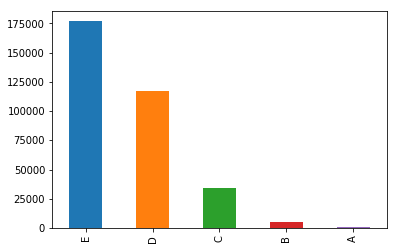

In [23]:
merchants['most_recent_sales_range'].value_counts().plot('bar');

In [27]:

import plotly.plotly as py 
import plotly.graph_objs as go

d = merchants['most_recent_purchases_range'].value_counts().sort_index()
e = merchants.loc[merchants['numerical_2'] < 0.1].groupby('most_recent_purchases_range')['numerical_1'].mean()

data = [go.Bar(x=d.index, y=d.values, name='counts'), go.Scatter(x=e.index, y=e.values, name='mean numerical_1', yaxis='y2')]
layout = go.Layout(dict(title = "Counts of values in categories of most_recent_purchases_range",
                        xaxis = dict(title = 'most_recent_purchases_range'),
                        yaxis = dict(title = 'Counts'),
                        yaxis2=dict(title='mean numerical_1', overlaying='y', side='right')),
                   legend=dict(orientation="v"))
py.iplot(dict(data=data, layout=layout))

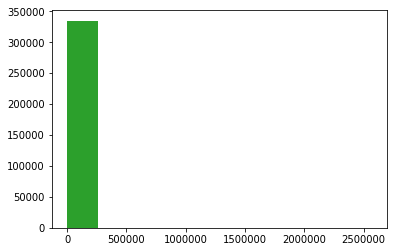

In [28]:
plt.hist(merchants['avg_sales_lag3'].fillna(0));
plt.hist(merchants['avg_sales_lag6'].fillna(0));
plt.hist(merchants['avg_sales_lag12'].fillna(0));

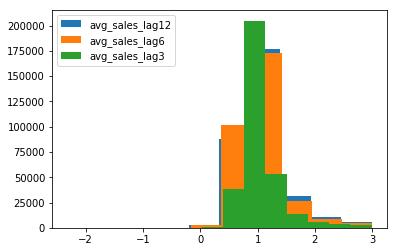

In [32]:
plt.hist(merchants.loc[(merchants['avg_sales_lag12'] < 3) & (merchants['avg_sales_lag12'] > -10), 'avg_sales_lag12'].fillna(0), label='avg_sales_lag12');
plt.hist(merchants.loc[(merchants['avg_sales_lag6'] < 3) & (merchants['avg_sales_lag6'] > -10), 'avg_sales_lag6'].fillna(0), label='avg_sales_lag6');
plt.hist(merchants.loc[(merchants['avg_sales_lag3'] < 3) & (merchants['avg_sales_lag3'] > -10), 'avg_sales_lag3'].fillna(0), label='avg_sales_lag3');
plt.legend();

In [33]:
merchants.loc[merchants['avg_purchases_lag3'] == np.inf, 'avg_purchases_lag3'] = 6000
merchants.loc[merchants['avg_purchases_lag6'] == np.inf, 'avg_purchases_lag6'] = 6000
merchants.loc[merchants['avg_purchases_lag12'] == np.inf, 'avg_purchases_lag12'] = 6000

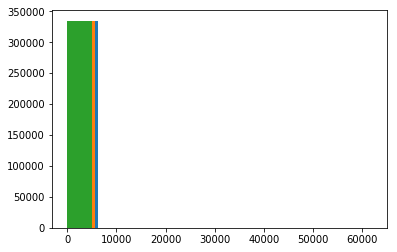

In [34]:
plt.hist(merchants['avg_purchases_lag3'].fillna(0));
plt.hist(merchants['avg_purchases_lag6'].fillna(0));
plt.hist(merchants['avg_purchases_lag12'].fillna(0));

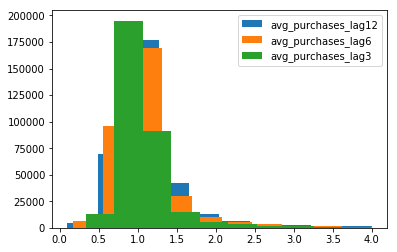

In [35]:
plt.hist(merchants.loc[(merchants['avg_purchases_lag12'] < 4), 'avg_purchases_lag12'].fillna(0), label='avg_purchases_lag12');
plt.hist(merchants.loc[(merchants['avg_purchases_lag6'] < 4), 'avg_purchases_lag6'].fillna(0), label='avg_purchases_lag6');
plt.hist(merchants.loc[(merchants['avg_purchases_lag3'] < 4), 'avg_purchases_lag3'].fillna(0), label='avg_purchases_lag3');
plt.legend();

In [36]:
for col in train.columns:
    if train[col].isna().any():
        train[col] = train[col].fillna(0)

In [37]:
for col in test.columns:
    if test[col].isna().any():
        test[col] = test[col].fillna(0)

In [38]:
col_to_drop = ['first_active_month', 'card_id', 'target']

In [39]:
train['feature_3'] = train['feature_3'].astype(int)
test['feature_3'] = test['feature_3'].astype(int)

In [40]:
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [49]:
X = train
X_test = test
y = train['target']

n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [50]:
def train_model(X=X, X_test=X_test, y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print('Fold {fold_n}. RMSE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

In [57]:
from catboost import CatBoostRegressor

cat_params = {'learning_rate': 0.01,
              'depth': 12,
              'l2_leaf_reg': 10,
              'bootstrap_type': 'Bernoulli',
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 50,
              'random_seed': 11,
              'allow_writing_files': False}

oof_cat, prediction_cat = train_model(params=cat_params, model_type='cat')

Fold 0 started at Mon Dec 24 17:51:18 2018


TypeError: Cannot convert 'b'2017-06'' to float

In [15]:
# save featured data
train.to_csv("train_featured.csv", index = False)
test.to_csv("test_featured.csv", index = False)

In [16]:
# drop card_id before running model
train = train.drop('card_id', axis=1) #,'hist_avg_term','new_avg_term'
test = test.drop('card_id', axis=1) #,'hist_avg_term','new_avg_term'

## LightGBM Model
Approach:

1st round training: find out important features -> delete correlated features

2nd round training: final prediction only with selected features

### 1st round: run the model for extracting important features

In [17]:
# set default parameters for 1st round training
params = {'boosting': 'gbdt',
          'objective':'regression',
          'metric': 'rmse',
          'learning_rate': 0.01, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.5,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1 #0.1
         }

In [18]:
# Reference: code from Ashish Patel(阿希什)Repeated KFOLD Approach: RMSE[3.70]
# Kfold cross-validation
# folds = KFold(n_splits=5, shuffle=True, random_state=11)

nfolds = 5
nrepeats = 2 
folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
fold_pred = np.zeros(len(train))
feature_importance_df = pd.DataFrame()
lgb_preds = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values,target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx]) #categorical_feature=categorical_feats

    iteration = 2000
    lgb_m = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    fold_pred[val_idx] = lgb_m.predict(train.iloc[val_idx], num_iteration=lgb_m.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = lgb_m.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_preds += lgb_m.predict(test, num_iteration=lgb_m.best_iteration) / (nfolds*nrepeats)

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, target))))

fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.59659	valid_1's rmse: 3.76442
[200]	training's rmse: 3.48093	valid_1's rmse: 3.72561
[300]	training's rmse: 3.40627	valid_1's rmse: 3.71202
[400]	training's rmse: 3.35248	valid_1's rmse: 3.70644
[500]	training's rmse: 3.30649	valid_1's rmse: 3.70345
[600]	training's rmse: 3.26588	valid_1's rmse: 3.70149
[700]	training's rmse: 3.22761	valid_1's rmse: 3.70168
Early stopping, best iteration is:
[628]	training's rmse: 3.2553	valid_1's rmse: 3.70115
fold n°1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.61369	valid_1's rmse: 3.67839
[200]	training's rmse: 3.4947	valid_1's rmse: 3.65052
[300]	training's rmse: 3.41853	valid_1's rmse: 3.63941
[400]	training's rmse: 3.36313	valid_1's rmse: 3.63444
[500]	training's rmse: 3.31696	valid_1's rmse: 3.6317
[600]	training's rmse: 3.27488	valid_1's rmse: 3.63048
[700]	training's rmse: 3.23147	valid_1's rmse: 3.62955

In [19]:
# ranking all feature by avg importance score from Kfold, select top 100
all_features = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
all_features.reset_index(inplace=True)
important_features = list(all_features[0:100]['feature'])
all_features[0:100]

,feature,importance
0,hist_category_1_sum,1680.8
1,new_purchase_amount_max,1601.8
2,new_weekofyear_max,1467.1
3,hist_authorized_flag_mean,1466.9
4,hist_pur_date_max,1290.4
5,hist_installments_sum,1284.2
6,hist_category_1_mean,1247.7
7,hist_purchase_amount_mean,1180.4
8,hist_month_lag_mean,1178.4
9,new_purchase_amount_mean,1159.7


In [20]:
# Check feature correlation 
# important_features = list(final_importance['feature'][0:60])
df = train[important_features]
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
high_cor = [column for column in upper.columns if any(upper[column] > 0.95)]
print(len(high_cor))
print(high_cor)

21
['hist_purchase_amount_max', 'hist_purchase_amount_std', 'hist_purchase_amount_sum', 'new_purchase_month_mean', 'hist_purchase_amount_nunique', 'new_pur_date_min', 'hist_authorized_flag_sum', 'hist_weekofyear_mean', 'hist_month_lag_nunique', 'new_month_diff_mean', 'hist_month_diff_min', 'new_month_diff_min', 'hist_month_lag_min', 'new_purchase_month_max', 'new_purchase_month_min', 'new_purchase_year_std', 'new_purchase_amount_nunique', 'new_merchant_id_nunique', 'new_subsector_id_nunique', 'hist_purchase_month_min', 'hist_purchase_month_max']


In [23]:
# final selected features: drop highly correlated features from important features.
features = [i for i in important_features if i not in high_cor]
print(len(features))
print(features)

79
['hist_category_1_sum', 'new_purchase_amount_max', 'new_weekofyear_max', 'hist_authorized_flag_mean', 'hist_pur_date_max', 'hist_installments_sum', 'hist_category_1_mean', 'hist_purchase_amount_mean', 'hist_month_lag_mean', 'new_purchase_amount_mean', 'howlong', 'hist_merchant_id_nunique', 'new_pur_date_ptp', 'new_weekofyear_min', 'hist_hour_mean', 'hist_purchase_amount_min', 'hist_weekofyear_nunique', 'hist_dayofweek_mean', 'new_purchase_amount_std', 'hist_pur_date_min', 'hist_month_diff_mean', 'new_hour_mean', 'new_weekofyear_mean', 'hist_weekend_mean', 'new_purchase_amount_min', 'hist_month_lag_std', 'hist_purchase_month_std', 'hist_purchase_month_nunique', 'hist_pur_date_ptp', 'hist_merchant_category_id_nunique', 'hist_cat3_B_mean', 'new_pur_date_max', 'hist_cat2_1.0_mean', 'hist_card_id_size', 'hist_installments_std', 'hist_weekend_sum', 'new_month_lag_mean', 'new_purchase_amount_sum', 'hist_weekofyear_max', 'hist_cat3_C_mean', 'new_hour_min', 'hist_weekofyear_min', 'hist_insta

## 2nd round: Train model with selected important_features only

In [22]:
# params for 2nd round training
params = {'boosting': 'gbdt',
          'objective':'regression',
          'metric': 'rmse',
          'learning_rate': 0.003, # 0.003! #0.005 #0.006 
          'num_leaves': 110, #110 #100 #150 large, but over-fitting
          'max_bin': 66,  #60 #50 # large,but slower,over-fitting
          'max_depth': 10, # deal with over-fitting
          'min_data_in_leaf': 30, # deal with over-fitting
          'min_child_samples': 20,
          'feature_fraction': 0.8,#0.5 #0.6 #0.8
          'bagging_fraction': 0.8,
          'bagging_freq': 40,#5  
          'bagging_seed': 11,
          'lambda_l1': 2,#1.3! #5 #1.2 #1
          'lambda_l2': 0.1 #0.1
         }

In [24]:
train = train[features]
test = test[features]

In [25]:
# Use Kfold predict
nfolds = 5
nrepeats = 2 

folds = RepeatedKFold(n_splits=nfolds, n_repeats=nrepeats, random_state=11)
fold_pred = np.zeros(len(train))
lgb_preds = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)): #target.values
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx]) #categorical_feature=categorical_feats
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx]) #categorical_feature=categorical_feats

    iteration = 3000
    lgb_model = lgb.train(params, trn_data, iteration, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    fold_pred[val_idx] = lgb_model.predict(train.iloc[val_idx], num_iteration=lgb_model.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train.columns
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_preds += lgb_model.predict(test, num_iteration=lgb_model.best_iteration) / (nfolds*nrepeats)

print("CV score: {:<8.5f}".format(np.sqrt(mean_squared_error(fold_pred, target))))


fold n°0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.73345	valid_1's rmse: 3.84506
[200]	training's rmse: 3.65947	valid_1's rmse: 3.80134
[300]	training's rmse: 3.60319	valid_1's rmse: 3.77292
[400]	training's rmse: 3.55825	valid_1's rmse: 3.75488
[500]	training's rmse: 3.52039	valid_1's rmse: 3.74229
[600]	training's rmse: 3.48814	valid_1's rmse: 3.73214
[700]	training's rmse: 3.46104	valid_1's rmse: 3.7256
[800]	training's rmse: 3.43597	valid_1's rmse: 3.7219
[900]	training's rmse: 3.41454	valid_1's rmse: 3.71826
[1000]	training's rmse: 3.3963	valid_1's rmse: 3.71585
[1100]	training's rmse: 3.38015	valid_1's rmse: 3.71372
[1200]	training's rmse: 3.36373	valid_1's rmse: 3.71181
[1300]	training's rmse: 3.34854	valid_1's rmse: 3.71035
[1400]	training's rmse: 3.33217	valid_1's rmse: 3.70889
[1500]	training's rmse: 3.31768	valid_1's rmse: 3.7085
Early stopping, best iteration is:
[1480]	training's rmse: 3.32045	valid_1's rmse: 3.70839
fold n°1
T

[100]	training's rmse: 3.74362	valid_1's rmse: 3.79297
[200]	training's rmse: 3.66841	valid_1's rmse: 3.75399
[300]	training's rmse: 3.61053	valid_1's rmse: 3.72973
[400]	training's rmse: 3.56447	valid_1's rmse: 3.71468
[500]	training's rmse: 3.5267	valid_1's rmse: 3.70487
[600]	training's rmse: 3.49405	valid_1's rmse: 3.69728
[700]	training's rmse: 3.4653	valid_1's rmse: 3.69206
[800]	training's rmse: 3.44063	valid_1's rmse: 3.68824
[900]	training's rmse: 3.41826	valid_1's rmse: 3.68547
[1000]	training's rmse: 3.3977	valid_1's rmse: 3.68376
[1100]	training's rmse: 3.38018	valid_1's rmse: 3.68265
[1200]	training's rmse: 3.36316	valid_1's rmse: 3.68176
[1300]	training's rmse: 3.34711	valid_1's rmse: 3.68114
[1400]	training's rmse: 3.33088	valid_1's rmse: 3.68052
[1500]	training's rmse: 3.31393	valid_1's rmse: 3.67982
[1600]	training's rmse: 3.29944	valid_1's rmse: 3.67989
Early stopping, best iteration is:
[1524]	training's rmse: 3.31032	valid_1's rmse: 3.67957
fold n°8
Training until v

In [26]:
# training data label 
target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [27]:
# predicted values
pd.DataFrame(lgb_preds).describe()

,0
count,123623.000000
mean,-0.393772
std,1.145506
min,-19.591238
25%,-0.631376
50%,-0.209751
75%,0.142844
max,3.015180


In [2]:
# predicted value distribution
%matplotlib inline

import matplotlib.pyplot as plt

num_bins = 100
n, bins, patches = plt.hist(lgb_preds, num_bins, facecolor='blue', alpha=0.5)
plt.show()

In [29]:
# Add target value to submition file
lgb_submission["target"] = lgb_preds
lgb_submission.to_csv("lgb_submission.csv", index=False)

In [30]:
# feature importance
final_importance = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)
final_importance.reset_index(inplace=True)
final_importance[0:50]

,feature,importance
0,hist_purchase_amount_mean,5528.6
1,hist_authorized_flag_mean,5437.5
2,hist_pur_date_max,5330.5
3,new_purchase_amount_max,5291.5
4,hist_category_1_sum,5098.7
5,new_weekofyear_max,5068.1
6,new_weekofyear_min,4545.8
7,new_pur_date_max,4156.0
8,howlong,4120.6
9,hist_month_lag_mean,4055.6


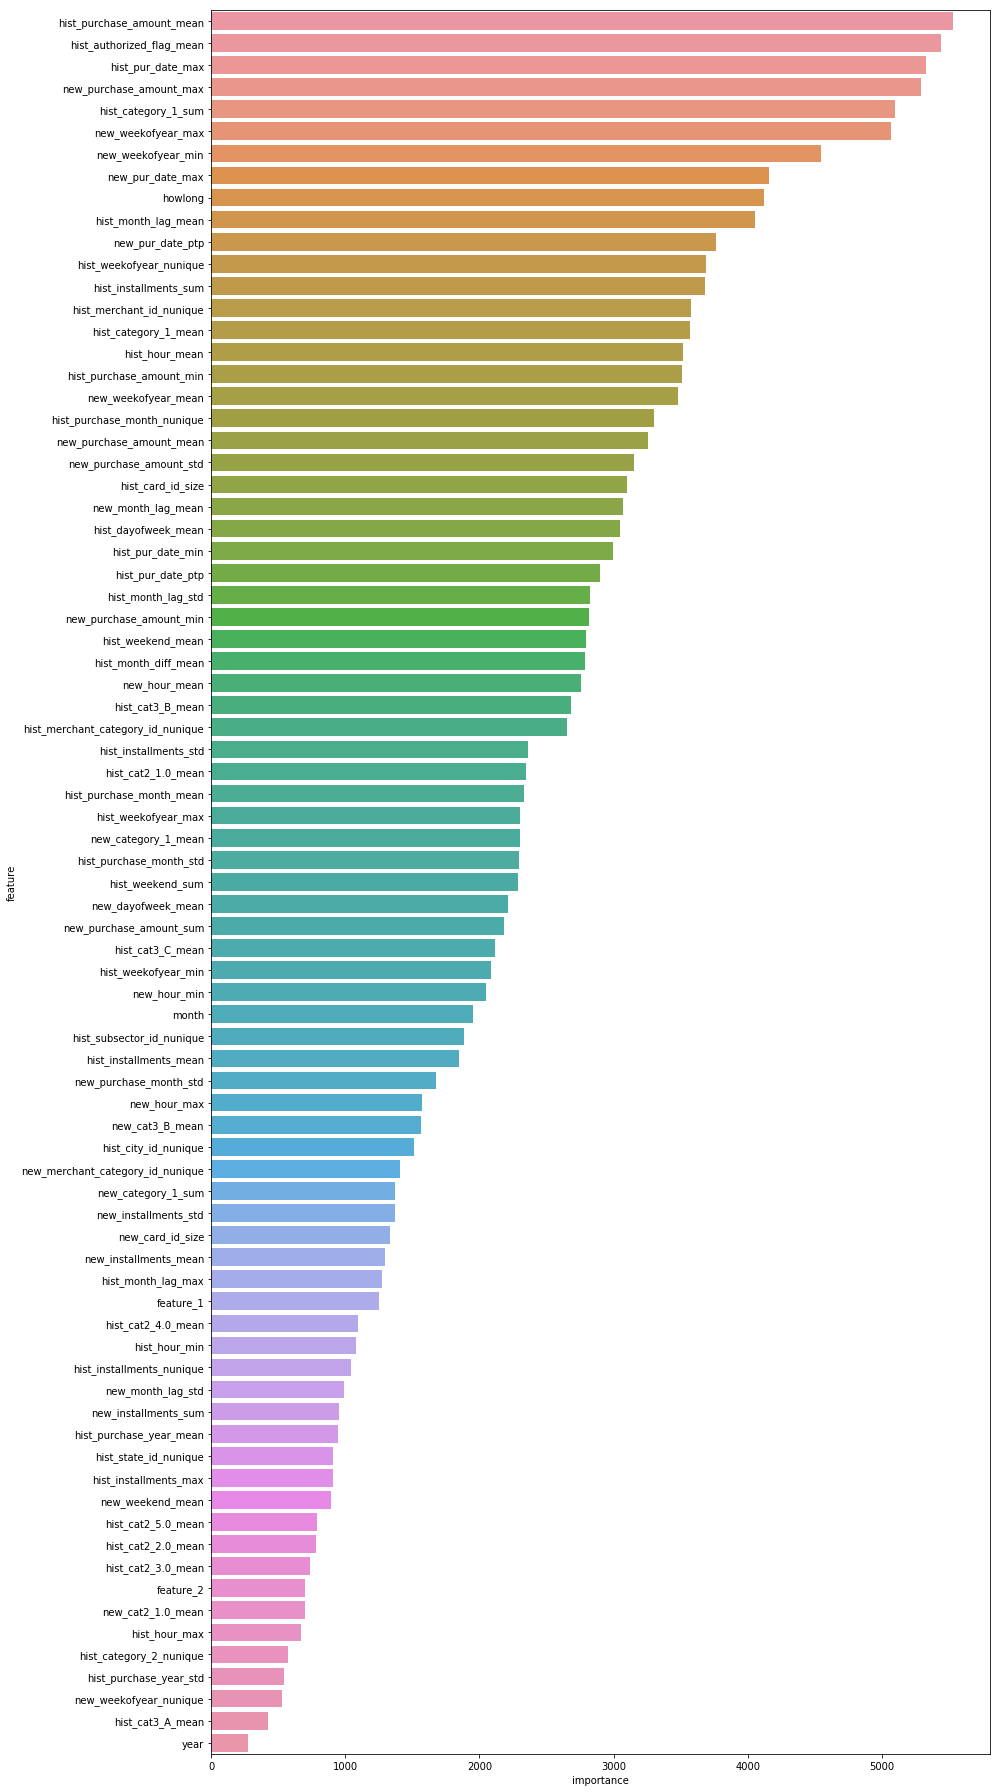

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,25))
sns.barplot(x="importance",y="feature",data=final_importance)
plt.tight_layout()
plt.savefig('lgbm_importances.png')